# 导入需要的模块

In [1]:
# import 需要的模块
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os
import zipfile
import struct
import seaborn as sns
from sklearn.metrics import confusion_matrix

2023-03-03 18:36:54,572-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2023-03-03 18:36:55,169-INFO: generated new fontManager


# 准备数据集

这里的数据集来源是MNIST数据集，包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

由于需要同时识别白底黑字和黑底白字两种，MNIST数据集为黑底白字，所以这里使用了公开的数据集，这个数据集是在MNIST数据集的基础上加以处理得来的，包含60000个训练集和10000测试数据集，在原有数据集的基础上将黑底白字换成了白底黑字。

**实验中的数据集是将MNIST数据集和这个公开数据集混合而成的新数据集。**


## 读取数据集

In [2]:
# 解压白底黑字数据集
train_file = zipfile.ZipFile("/home/aistudio/data/data36874/train.zip") 
train_file.extractall("/home/aistudio/data/data36874")

test_file = zipfile.ZipFile("/home/aistudio/data/data36874/test.zip")
test_file.extractall("/home/aistudio/data/data36874")

# 白底黑字训练集标签
train_labels_idx1 = "/home/aistudio/data/data36874/train_examples_labels/train-labels.idx1-ubyte"

# 白底黑字测试集标签
test_labels_idx1 = "/home/aistudio/data/data36874/test_examples_labels/t10k-labels.idx1-ubyte"

## 加载和解析标签

In [3]:
def decode_idx1(idx1_ubyte_file):
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, "rb").read()
 
    # 解析文件头信息
    offset = 0
    fmt_header = ">ii"
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
 
    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = ">B"
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    
    return labels


train_label = decode_idx1(train_labels_idx1)
test_label = decode_idx1(test_labels_idx1)

## 预处理图片并创建 reader

In [4]:
# 图片预处理
def image_data_format(file_url):
    img = Image.open(file_url).convert('L')
    img = img.resize((28, 28), Image.ANTIALIAS)
    img = np.array(img).reshape(1, 1, 28, 28).astype(np.float32)
    img = img / 255.0 * 2.0 - 1.0
    img = img.reshape(28 * 28)
    return img

# 创建 data
def create_data(dir_name, isTest):
    data = []
    data_urls = []
    data_list = os.listdir(dir_name)
    for i in range(0, len(data_list)):
        file_url = os.path.join(dir_name, data_list[i])
        data_urls.append(file_url)
    if isTest:
        data_urls.sort(key = lambda x: int(x[60:-4]))
    else:
        data_urls.sort(key = lambda x: int(x[62:-4]))

    for data_url in data_urls:
        # 将预处理的图片添加到 data list 里
        data.append(image_data_format(data_url))

    return data


# 创建 reader
def create_data_reader(data, label):
    def reader():
        for i in  range(len(data)):
            yield data[i], int(label[i])
    return reader

train_data_reader = create_data_reader(create_data("/home/aistudio/data/data36874/train_examples_labels/train_new", False), train_label)
test_data_reader = create_data_reader(create_data("/home/aistudio/data/data36874/test_examples_labels/test_new", True), test_label)

## 混合数据集并进行随机选择

In [5]:
# 缓存区数据数目
BUF_SIZE = 512
# 每次提取数据数目
BATCH_SIZE = 128

# 混合两个数据集
# 每次读取数据集中的 BUF_SIZE 个数据并进行随机
# reader 每次取出 BATCH_SIZE 个数据
train_reader = paddle.batch(paddle.reader.shuffle(paddle.reader.chain(paddle.dataset.mnist.train(), train_data_reader), buf_size=BUF_SIZE), batch_size=BATCH_SIZE)
test_reader = paddle.batch(paddle.reader.chain(paddle.dataset.mnist.test(), test_data_reader), batch_size=BATCH_SIZE)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


至此，数据集生成完毕，生成的数据集同时包括白底黑字和黑底白字的数据。

# 设计网络

这里使用了两个经典的卷积神经网络，分别是 Lenet-5 和 VGG。

## Lenet-5

In [6]:
# 使用 Lenet-5 卷积神经网络
def lenet_5_net():
    data_type = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')

    conv1 = fluid.layers.conv2d(data_type, 6, filter_size=5, stride=1, padding=2, act='relu')
    pool1 = fluid.layers.pool2d(conv1, 2, pool_stride=2, pool_type='max')

    conv2 = fluid.layers.conv2d(pool1, 16, filter_size=5, stride=1, padding=0, act='relu')
    pool2 = fluid.layers.pool2d(conv2, 2, pool_stride=2, pool_type='max')

    conv3 = fluid.layers.conv2d(pool2, 120, filter_size=5, stride=1, padding=0, act='relu')

    flatten = fluid.layers.flatten(conv3, axis=1)
    fc1 = fluid.layers.fc(flatten, 84, act='relu')
    fc2 = fluid.layers.fc(fc1, 10, act='softmax')

    return fc2


## VGG

In [7]:
# 使用 VGG 卷积神经网络
def vgg_net():
    data_type = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')

    conv1 = fluid.layers.conv2d(data_type, num_filters=128, filter_size=3, stride=1, padding=3, act='relu')
    pool1 = fluid.layers.pool2d(conv1, pool_size=2, pool_stride=2, pool_type='max')

    conv2 = fluid.layers.conv2d(pool1, num_filters=256, filter_size=3, stride=1, padding=1, act='relu')
    pool2 = fluid.layers.pool2d(conv2, pool_size=2, pool_stride=2, pool_type='max')

    conv3 = fluid.layers.conv2d(pool2, num_filters=768, filter_size=3, stride=1, padding=1, act='relu')
    pool3 = fluid.layers.pool2d(conv3, pool_size=2, pool_stride=2, pool_type='max')

    conv4 = fluid.layers.conv2d(pool3, num_filters=1536, filter_size=3, stride=1, padding=1, act='relu')
    pool4 = fluid.layers.pool2d(conv4, pool_size=2, pool_stride=2, pool_type='max')

    conv5 = fluid.layers.conv2d(pool4, num_filters=1536, filter_size=3, stride=1, padding=1, act='relu')
    pool5 = fluid.layers.pool2d(conv5, pool_size=2, pool_stride=2, pool_type='max')

    drop = fluid.layers.dropout(x=pool5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(drop, size=256, act=None)
    bn = fluid.layers.batch_norm(fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.0)
    fc2 = fluid.layers.fc(drop2, size=256, act=None)
    fc3 = fluid.layers.fc(fc2, size=10, act='softmax')

    return fc3

# 网络搭建

## 选择模型

In [8]:
# 当前使用的模型
# model = lenet_5_net()
model = vgg_net()

## 选择训练方式

In [9]:
# CPU
# place = fluid.CPUPlace()

# GPU
place = fluid.CUDAPlace(0)

## 定义数据层

输入的图像数据是 28 * 28 的灰度图，灰度图只有一个通道，所以输入的形状是[1, 28, 28]

In [10]:
# 输入的原始图像数据，大小为 1 * 28 * 28
image = fluid.layers.data(name="image", shape=[1, 28, 28], dtype="float32")

# 输入图片的标签
label = fluid.layers.data(name="label", shape=[1], dtype="int64")

## 数据转换

DataFeeder 负责将数据提供器返回的数据进行转换，方便传入

In [11]:
# 告知网络传入的数据分为两部分，第一部分是 image 值，第二部分是 label 值
feeder = fluid.DataFeeder(feed_list=[image, label], place=place)

## 定义损失函数和准确率

这里使用的是在分类任务上常见的交叉熵损失函数

同时需要对损失函数定义一个平均值，平均损失作为第一个返回值，被用于反向传播

定义的准确率函数可以方便的输出分类的准确率

In [12]:
# 交叉熵损失函数
cost_function = fluid.layers.cross_entropy(input=model, label=label)
# 平均损失
avg_cost = fluid.layers.mean(cost_function)
# 计算分类准确率
acc = fluid.layers.accuracy(input=model, label=label)

## 定义优化器和学习率

这里选择了四种优化器和三种学习率，具体请参考文档

In [13]:
# 学习率
# LEARNING_RATE = 0.0005
# LEARNING_RATE = 0.001
LEARNING_RATE = 0.0015

# Adam 优化器
# optimizer = fluid.optimizer.Adam(learning_rate=LEARNING_RATE)
# SGD 优化器
# optimizer = fluid.optimizer.SGD(learning_rate=LEARNING_RATE)
# RMSProp 优化器
# optimizer = fluid.optimizer.RMSProp(learning_rate=LEARNING_RATE)
# Adagrad 优化器
optimizer = fluid.optimizer.AdagradOptimizer(learning_rate=LEARNING_RATE)

opts = optimizer.minimize(avg_cost)

# 模型训练

## 参数设置

In [14]:
# 训练次数
TRAIN_TIME = 15
# 保存路径
save_path = "/home/aistudio/work/hand_inference.model"

## 训练过程

In [15]:
executor = fluid.Executor(place)
executor.run(fluid.default_startup_program())
main_program = fluid.default_main_program()
test_program = fluid.default_main_program().clone(for_test=True)

step = 0
lists = []
x = []
y = []
z = []

predict_output_list = []
answer_output_list = []

for train_time in range(TRAIN_TIME):
    for step_id, data in enumerate(train_reader()):
        metrics = executor.run(main_program, feed=feeder.feed(data), fetch_list=[avg_cost, acc])
        # 每 200 个打印一次
        if step % 200 == 0:
            print("==> 训练次数：%d  ==> 训练轮数：%d  ==> 损失：%f" % (step, train_time, metrics[0]))
        step += 1

    # 验证
    acc_list = []
    avg_loss_list = []
    for test_data in test_reader():
        predict_output, acc_np, avg_np = executor.run(program=test_program, feed=feeder.feed(test_data), fetch_list=[model, acc, avg_cost])
        acc_list.append(acc_np)
        avg_loss_list.append(avg_np)
        
        # 记录验证时的结果和输出
        if train_time == TRAIN_TIME - 1:
            predict_output_list.append(predict_output)
            answer_output_list.append([int(d[1]) for d in test_data])

    acc_val_mean = np.array(acc_list).mean()
    avg_loss_mean = np.array(avg_loss_list).mean()
    lists.append((train_time, avg_loss_mean, acc_val_mean))

    x.append(train_time)
    y.append(acc_val_mean)
    z.append(avg_loss_mean)

    # 打印本轮信息
    print("======> 第 %d 轮 ======> 平均损失率：%s ======> 平均准确度：%s\n" % (train_time, avg_loss_mean, acc_val_mean))

    if save_path is not None:
        fluid.io.save_inference_model(save_path, ["image"], [model], executor, model_filename=None, params_filename=None)

best = sorted(lists, key=lambda list: float(list[1]))[0]
print("==========> 最好为第 %s 轮数：平均损失率：%s <==========" % (best[0], best[1]))
print("==========> 分类准确度：%.2f%% <==========" % (float(best[2]) * 100))

W0303 18:39:39.793563    97 device_context.cc:237] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 11.2, Runtime API Version: 9.0
W0303 18:39:39.840368    97 device_context.cc:245] device: 0, cuDNN Version: 7.6.


==> 训练次数：0  ==> 训练轮数：0  ==> 损失：2.837360
==> 训练次数：200  ==> 训练轮数：0  ==> 损失：0.033713
==> 训练次数：400  ==> 训练轮数：0  ==> 损失：0.028658
==> 训练次数：600  ==> 训练轮数：0  ==> 损失：0.047676
==> 训练次数：800  ==> 训练轮数：0  ==> 损失：0.043431
======> 第 0 轮 ======> 平均损失率：0.09894375 ======> 平均准确度：0.9701433

==> 训练次数：1000  ==> 训练轮数：1  ==> 损失：0.038209
==> 训练次数：1200  ==> 训练轮数：1  ==> 损失：0.053156
==> 训练次数：1400  ==> 训练轮数：1  ==> 损失：0.001893
==> 训练次数：1600  ==> 训练轮数：1  ==> 损失：0.018705
==> 训练次数：1800  ==> 训练轮数：1  ==> 损失：0.023209
======> 第 1 轮 ======> 平均损失率：0.031687174 ======> 平均准确度：0.9898985

==> 训练次数：2000  ==> 训练轮数：2  ==> 损失：0.003367
==> 训练次数：2200  ==> 训练轮数：2  ==> 损失：0.006503
==> 训练次数：2400  ==> 训练轮数：2  ==> 损失：0.022752
==> 训练次数：2600  ==> 训练轮数：2  ==> 损失：0.012078
==> 训练次数：2800  ==> 训练轮数：2  ==> 损失：0.001555
======> 第 2 轮 ======> 平均损失率：0.04235137 ======> 平均准确度：0.98815686

==> 训练次数：3000  ==> 训练轮数：3  ==> 损失：0.022730
==> 训练次数：3200  ==> 训练轮数：3  ==> 损失：0.004467
==> 训练次数：3400  ==> 训练轮数：3  ==> 损失：0.005373
==> 训练次数：3600  ==> 训练轮数：3  ==> 损失：0.001

## 绘制准确率与损失图

准确率与损失图


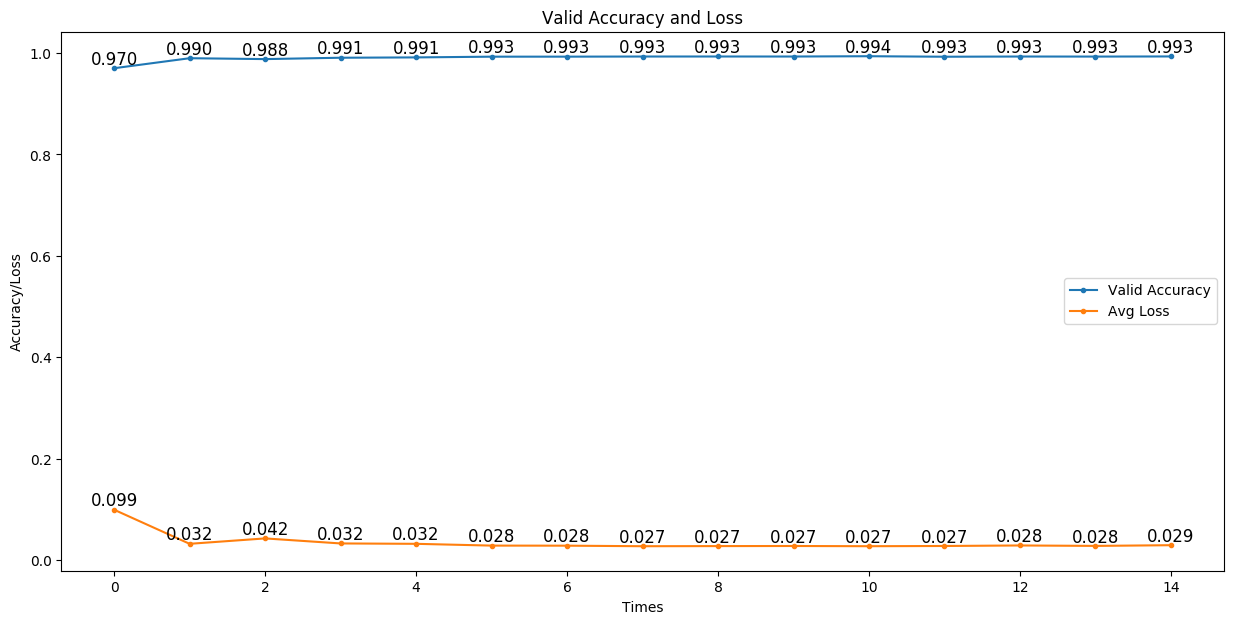

In [16]:
plt.figure(figsize=(15, 7))
plt.title("Valid Accuracy and Loss")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Times")

plt.plot(x, y, '.-', label="Valid Accuracy")
plt.plot(x, z, '.-', label="Avg Loss")

plt.legend(loc="best")
for x_label, y_label in zip(x, y):
    plt.text(x_label, y_label, (format(y_label, ".3f")), ha="center", va="bottom", fontsize=12)
for x_label, z_label in zip(x, z):
    plt.text(x_label, z_label, (format(z_label, ".3f")), ha='center', va='bottom', fontsize=12)

print("准确率与损失图")
plt.show()

## 输出混淆矩阵

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


混淆矩阵


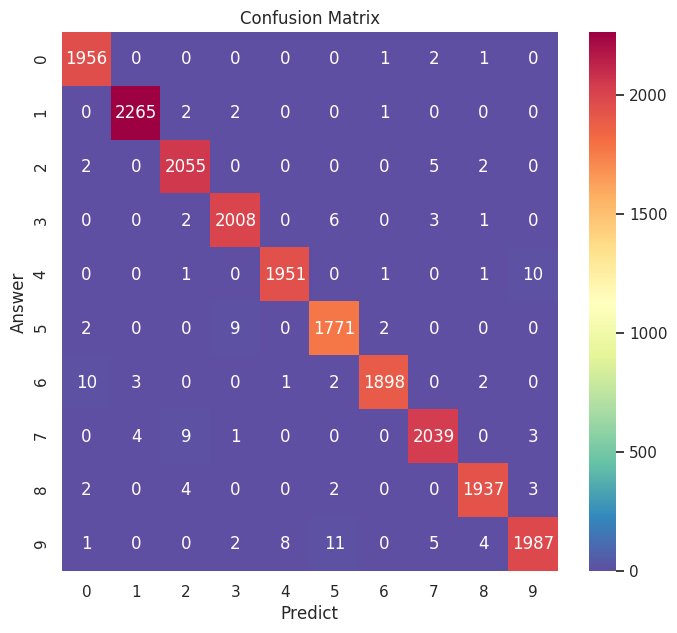

In [17]:
predict_label_list = []
answer_label_list = []

for predict_output in np.array(predict_output_list):
    for label in predict_output:
        predict_label_list.append(np.argsort(label)[-1])

for answer_output in np.array(answer_output_list):
    for label in answer_output:
        answer_label_list.append(label)

sns.set()
f, ax = plt.subplots(figsize=(8, 7))
C2 = confusion_matrix(answer_label_list, predict_label_list, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TX = sns.heatmap(C2, annot=True, ax=ax, cmap="Spectral_r", fmt=".20g")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predict")
ax.set_ylabel("Answer")

print("混淆矩阵")

# 手写数字识别

这里使用了两张图片进行手写数字识别

一张是白底黑字的 2 

一张是黑底白字的 9

## 图片预处理

先进行灰度化，然后压缩图像大小为 28 * 28 

然后将图像转换成一维向量，最后对一维向量进行归一化处理

In [23]:
def load_image(file):
    im = Image.open(file).convert("L")                        #将RGB转化为灰度图像，L代表灰度图像，像素值在0~255之间
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
    im = im / 255.0 * 2.0 - 1.0                               #归一化到【-1~1】之间
    return im

image_2 = load_image("/home/aistudio/data/data36916/white_2.png")
image_9 = load_image("/home/aistudio/data/data36916/black_9.jpg")

## 识别白底黑字的数字

这里是白底黑字的数字 2

识别数字并显示图片

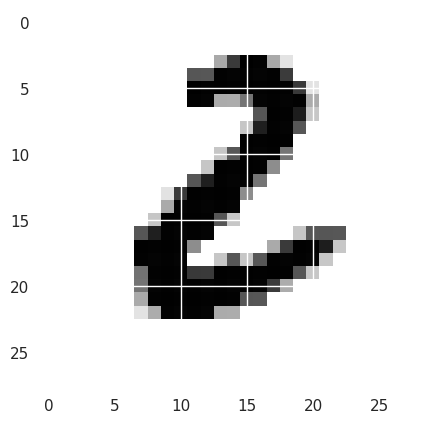

这张白底黑字的数字 2 的识别结果是: 2


In [25]:
executor = fluid.Executor(place)
inference_scope = fluid.core.Scope()

with fluid.scope_guard(inference_scope):
    # 加载模型
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(save_path, executor, None, None)
    
    # 运行识别
    results = executor.run(inference_program, feed={feed_target_names[0]: image_2}, fetch_list=fetch_targets)

    # 获取概率最大的 label
    lab = np.argsort(results)

    # 显示图片
    plt.imshow(Image.open("/home/aistudio/data/data36916/white_2.png"))
    plt.show()

    # 输出这张图片的识别结果
    print("这张白底黑字的数字 2 的识别结果是: %d" % lab[0][0][-1])

## 识别黑底白字的数字

这里是黑底白字的数字 9

识别数字并显示图片

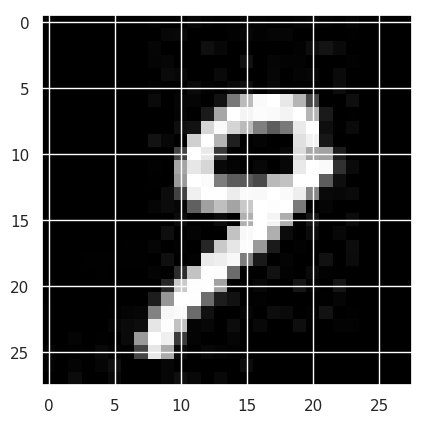

这张黑底白字的数字 9 的识别结果是: 9


In [26]:
executor = fluid.Executor(place)
inference_scope = fluid.core.Scope()

with fluid.scope_guard(inference_scope):
    # 加载模型
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(save_path, executor, None, None)
    
    # 运行识别
    results = executor.run(inference_program, feed={feed_target_names[0]: image_9}, fetch_list=fetch_targets)

    # 获取概率最大的 label
    lab = np.argsort(results)

    # 显示图片
    plt.imshow(Image.open("/home/aistudio/data/data36916/black_9.jpg"))
    plt.show()

    # 输出这张图片的识别结果
    print("这张黑底白字的数字 9 的识别结果是: %d" % lab[0][0][-1])